# ISPC phase searc match

Notebook iterating gamma. I use this to generate experimental phases used for the analysis.

### Imports

In [1]:
from XRDXRFutils import (Phase, DatabaseXRD, DataXRF, DataXRD, SpectraXRD, FastSpectraXRD, GaussNewton,
    PhaseList, ChiSearch, GammaMap, ChiMap, Phase, PhaseList, GammaSearch_Secondary, GammaMap_Secondary)

from os.path import isdir
from os import makedirs
from shutil import rmtree

import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import linspace, concatenate, sqrt, log, sin, pi, histogram, array, unravel_index, savetxt, flip, sum, average, amax
import pandas as pd

from matplotlib.pyplot import (sca, show, fill_between, legend, imshow, subplots, plot, xlim, ylim,
                               xlabel, ylabel, cm, title, scatter, colorbar, figure, vlines, savefig, rcParams)
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from matplotlib.markers import MarkerStyle

from sklearn.cluster import KMeans, MiniBatchKMeans

from multiprocessing import Pool

from glob import glob
from PIL import Image

from pathlib import Path

def f_linear(x,a,b):
    return a*x + b

def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

rcParams.update({
'image.origin': 'lower'
})

# Define Paths and Spectra Parameters

In [2]:
#path_shared = '/home/shared/'
path_shared = '../../shared/'

path_xrd = path_shared + 'dataXRDXRF/MunchMuseum/M491/ProfiloXRD/' # XRD scan
path_zmap = path_shared + 'VenereBZPosition/'
path_xrf = path_shared + 'dataXRDXRF/MunchMuseum/M491/ProfiloXRF/labels/' # XRF scan
path_photo = path_shared + 'dataXRDXRF/MunchMuseum/M491/ProfiloFoto/' # photo of the scanned section
path_database = path_shared + 'Database/' # tabulated phases

subfolder_output = 'Munch/M491/ProfiloXRD/'
path_figures = 'figures/' + subfolder_output # figures generated by the script
path_results = 'results/' + subfolder_output # results generated by the script: raw data, tif maps
path_database_exp = 'databaseEXP/' + subfolder_output # experimental phases

min_theta = 22
max_theta = 53
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)

sigma = 0.17

#### To reset results, delete output folders.
WARNING: every result will be lost

In [3]:
# rmtree(path_figures)
# rmtree(path_results)
# rmtree(path_database_exp)

#### Check if output folders exist. If not, create them.

In [4]:
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)
if not isdir(path_database_exp):
    makedirs(path_database_exp)

# Show photo of scanned section

In [5]:
filenames = glob(path_photo + '*.jpg')
for filename in filenames:
    im = Image.open(filename)
    display(im.resize([s // 2 for s in im.size]))

# Read XRD Data and Database

In [6]:
%matplotlib inline
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').remove_background().save_h5(path_xrd + 'xrd.h5')
print(f'Shape of data: {data.shape}')
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

database = DatabaseXRD().read_cifs(path_database)
print('Phases in database:', len(database))

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
a: -1214.7 s: 1952.7 beta: 51.663
Phases in database: 318


### Show aggregated information on XRD data

In [7]:
rcParams['font.size'] = 18

fig, axs = subplots(3, 2, figsize = (20, 12))
fig.tight_layout(h_pad = 4, w_pad = 0)

list_aggregations = ['integral', 'average', 'maximum']
list_functions = [sum, average, amax]
for i in range(len(list_aggregations)):

    image_aggregated = list_functions[i](data.data, axis = 2)
    ax = axs[i, 0]
    im = ax.imshow(image_aggregated)
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 3))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(f'Aggregated image ({list_aggregations[i]})')

    xrdpattern_aggregated = list_functions[i](data.data.reshape((-1, data.data.shape[-1])), axis = 0)
    theta = data.fce_calibration(range(data.shape[-1]), *data.opt)
    ax = axs[i, 1]
    ax.plot(theta, xrdpattern_aggregated)
    ax.ticklabel_format(useMathText = True)
    ax.set_xlim(theta[0], theta[-1])
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel('rescaled intensity')
    ax.set_title(f'Aggregated signal ({list_aggregations[i]})')

savefig(f'{path_figures}aggregated_info.png', bbox_inches = 'tight', dpi = 300)
show()

# Read z position and laser correction

In [8]:
list_z = []
list_laser = []

filenames = sorted(glob(path_zmap + '/*.txt'))
for filename in filenames:
    df = pd.read_csv(filename, sep = '\s+')
    list_z.append(df['Z'].values)
    list_laser.append(df['Laser'].values)

matrix_z = array(list_z)
matrix_laser = array(list_laser)
matrix_sum_z_laser = matrix_z + matrix_laser

### Show maps

In [8]:
rcParams['font.size'] = 18

fig, ax  = subplots(figsize = (8, 6))
im = ax.imshow(matrix_z)
colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
ax.set_title('Z position')
show()

fig, ax  = subplots(figsize = (8, 6))
im = ax.imshow(matrix_laser)
colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
ax.set_title('Laser correction')
show()

fig, ax  = subplots(figsize = (8, 6))
im = ax.imshow(matrix_sum_z_laser)
colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
ax.set_title('Z position + laser correction')
show()

# Read XRF images

In [8]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = [1])
print(f'Found {data_xrf.labels.shape[2]} images')

Found 24 images


### Show XRF images

In [9]:
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(data_xrf.metadata['labels'])
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (6 * n_of_columns, 4 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, label in enumerate(data_xrf.metadata['labels']):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    im = ax.imshow(data_xrf.labels[..., i])
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(label)
show()

## Define phases

This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [10]:
hydrocerussite = database['Hydrocerussite'][0]
lazurite = database['Lazurite'][0]
cinnabar = database['Cinnabar'][1]
calcite = database['Calcite'][0]
cobalt_alluminate = database['Al2 Co O4'][0] # same formula as Spinel
spinel = database['Spinel'][0]
spinel2 = database['Al2 Co O4'][0]
lead_cromate_oxide = database['Cr O5 Pb2'][0]
hematite = database['Hematite'][0]
cristobalite = database['Cristobalite'][0]
goethite = database['Goethite'][0]
Mn3_O4 = database['Mn3 O4'][0]
barite = database['Barite'][0]
greenockite = database['Greenockite'][0] # same formula as Hawleyite
hawleyite = database['Hawleyite'][0]
bone = database['Carbonate-hydroxylapatite'][0]

### Explore phase database

See the phases in the database that contain all of the chosen elements.

For each phase we see:

mineral name (when available), chemical formula, number of samples in the database

In [11]:
elements_chosen = ['Co']

for v,k in sorted(database.items()):
    p = k[0]
    if '_chemical_formula_sum' in p:
        if all(e in p['_chemical_formula_sum'] for e in elements_chosen):
            if '_chemical_name_mineral' in p:
                print(p['_chemical_name_mineral'] + ', ', end = '\t')
            print(p['_chemical_formula_sum'] + ', ', end = '\t')
            print(len(k))

Al2 Co O4, 	2
As2 Co3 O8, 	4
As3 Co, 	1
Co Li O4 P, 	5
Co2 O4 Sn, 	1
Co3 O8 P2, 	2
CoAl2O4, 	Al2 Co O4, 	1
Erythrite, 	As4 Co4.02 Fe1.48 H32 Ni0.50 O32, 	1
Skutterudite, 	As3 Co, 	4
Sphaerocobaltite, 	C Co O3, 	1
Spinel, 	Al2 Co O4, 	17


### Plot XRF of selected element

In [14]:
#%matplotlib inline
%matplotlib qt

element_chosen = 'S'
rcParams['font.size'] = 12

for i, label in enumerate(data_xrf.metadata['labels']):
    #if element_chosen in label:   # search for the given string in XRF label
    if element_chosen + '_' in label:   # search for the given string + '_' in XRF label
        fig, ax  = subplots(figsize=(10,10))
        title(label)
        im = imshow(data_xrf.labels[..., i])
        colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
show()

### Check phases in a given point

In [12]:
%matplotlib inline
x, y = 145, 35
rcParams['font.size'] = 18

phases_new = PhaseList([hydrocerussite, cinnabar])
for p in phases_new:
    print(p.label, p['_chemical_formula_sum'])

gn = GaussNewton(phases_new, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

### Leaves initial calibration and only optimizes the heights of the peaks ###
#g.fit_cycle(gamma = True, steps = 16)

### Optimizes calibration and heights of the peaks ###
gn.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16).fit_cycle(gamma = True, steps = 16)

fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = f'Gauss-Newton')
fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label='overlap')
gn.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
gn.phase.plot(lw = 2.5, alpha = 1)
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'{gn.label}, overlap area = {gn.overlap_area():.1f}')
legend(frameon = False)
show()

Hydrocerussite C H O4 Pb1.5
Cinnabar Hg S


# Search for primary phases

Adjust initial calibration. This can be executed after the first fit finds a better initial calibration.

In [14]:
if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s

### Create data structure

In [15]:
#phases_primary = [hydrocerussite, lazurite, cinnabar, barite, greenockite]
phases_primary = [hydrocerussite, lazurite, cinnabar]

In [16]:
gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [17]:
%%time
gm = gm.search()

Using 8 CPUs
CPU times: user 7.3 s, sys: 1.53 s, total: 8.84 s
Wall time: 16.4 s


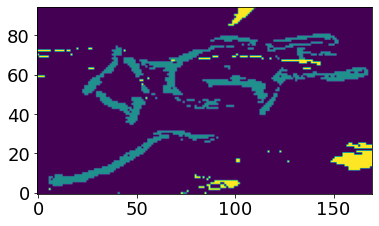

In [18]:
rcParams['font.size'] = 18
map_selected = gm.selected()
imshow(map_selected)
show()

In [19]:
%%time
L1loss, MSEloss, overlap_area = gm.metrics()
criterion = overlap_area * data.rescaling**0.5

Using 8 CPUs
CPU times: user 3.13 s, sys: 367 ms, total: 3.49 s
Wall time: 3.78 s


### Histogram of $a$

If $a$ is spead over too large area it means that fitting went wrong. Maybe we need to add phases.

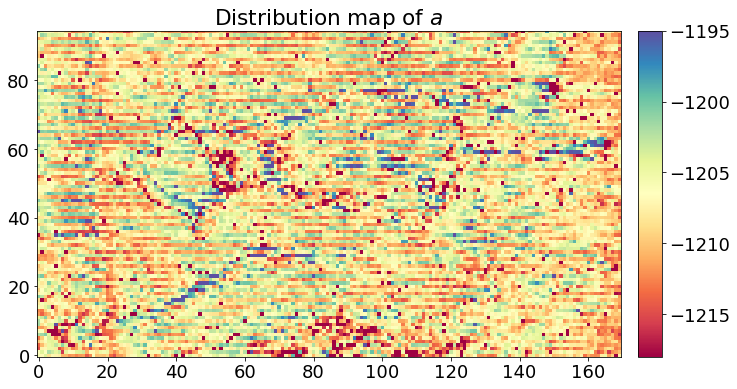

In [20]:
%matplotlib inline
rcParams['font.size'] = 18

opt = gm.opt()
a = opt[..., 0]
s = opt[..., 1]

vmin = -1218
vmax = -1195

h, b = histogram(a,bins=512)

fig, ax = subplots(figsize = (12, 4))
plot(b[:-1], h)
xlim(b[0], b[-1])
ylim(0,h.max())
vlines(vmin, 0, h.max(), 'k', ls = '--', lw = 1)
vlines(vmax, 0, h.max(), 'k', ls = '--', lw = 1)
xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')

fig, ax = subplots(figsize = (12, 6))
title('Distribution map of $a$')
im = imshow(a,cmap='Spectral',vmin=vmin,vmax=vmax)
colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

show()

## Plotting the $a,s$ dependence

There is a slight notion of a second $a, s$ dependence but it is weak.

Linear: [  -2.28207785 -805.81547241]
Cauchy: [ -0.88604355 878.07842002]
mean a,s: -1207.6166193911738 1950.0596615576128
most probable a,s: -1208.2573956750216 1948.6470864503954


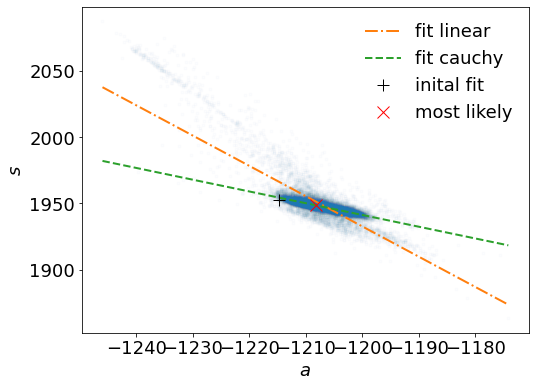

In [21]:
%matplotlib inline
rcParams['font.size'] = 18

opt, var = curve_fit(f_linear, a.flatten(), s.flatten())
res = least_squares(f_loss, x0 = opt, args = (a.flatten(), s.flatten()), loss = 'cauchy')
pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])
x = linspace(a.min(), a.max(), 10)
# linear_y = f_linear(a.flatten(), *opt)
# cauchy_y = f_linear(a.flatten(), *res['x'])

print('Linear:', opt)
print('Cauchy:', res['x'])
print('mean a,s:', a.mean(), s.mean())
print('most probable a,s:', pmax_a, pmax_s)

fig, ax = subplots(figsize = (8, 6))
ax.plot(a.flatten(), s.flatten(), '.', alpha = 0.01)
ax.plot(x, f_linear(x, *opt), '-.', lw = 2, label = 'fit linear')
ax.plot(x, f_linear(x, *res['x']), '--', lw = 2, label = 'fit cauchy')
ax.plot(data.opt[0], data.opt[1], 'k+', ms = 12, label = 'inital fit')
ax.plot(pmax_a, pmax_s, 'rx', ms = 12, label = 'most likely')
legend(frameon = False)
xlabel(r'$a$')
ylabel(r'$s$')
show()

### Criterion

Criterion for phase selection.

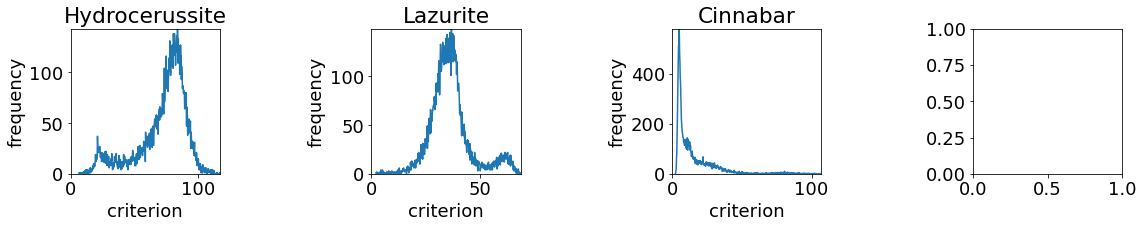

In [22]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 18

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 3 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    h, b = histogram(criterion[:, :, i], bins = 512)
    ax.plot(b[:-1], h)
    ax.set_xlim(0, b.max())
    ax.set_ylim(0, h.max())
    ax.set_xlabel('criterion')
    ax.set_ylabel('frequency')
    ax.set_title(phase.label)
show()

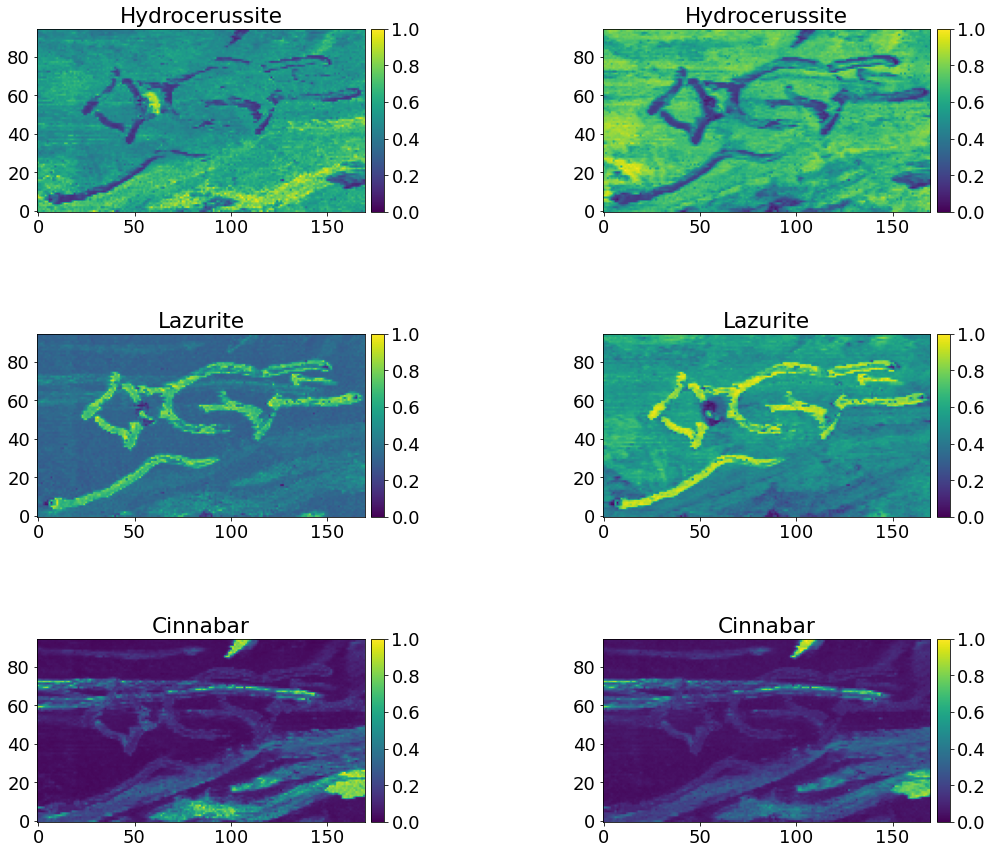

In [23]:
%matplotlib inline
rcParams['font.size'] = 18

fig, axs = subplots(len(gm.phases), 2, figsize = (15, 4 * len(gm.phases)))
fig.tight_layout(h_pad = 5, w_pad = 5)

for i, phase in enumerate(gm.phases):
    ax = axs[i, 0]
    ax.set_title(phase.label)
    matrix_plot = overlap_area[..., i]
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))

    ax = axs[i, 1]
    ax.set_title(phase.label)
    matrix_plot = criterion[..., i]
    matrix_plot /= matrix_plot.max()
    p = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))

show()

# Select experimental phases

In [24]:
experimental_phases = gm.select_phases(criterion, -5)

Hydrocerussite (13, 21) 3583 [-1202.06019474  1941.83510333    51.66346438]
Lazurite (62, 30) 5162 [-1205.27321713  1936.60052681    51.66346438]
Cinnabar (103, 89) 15233 [-1203.99937508  1942.92230671    51.66346438]


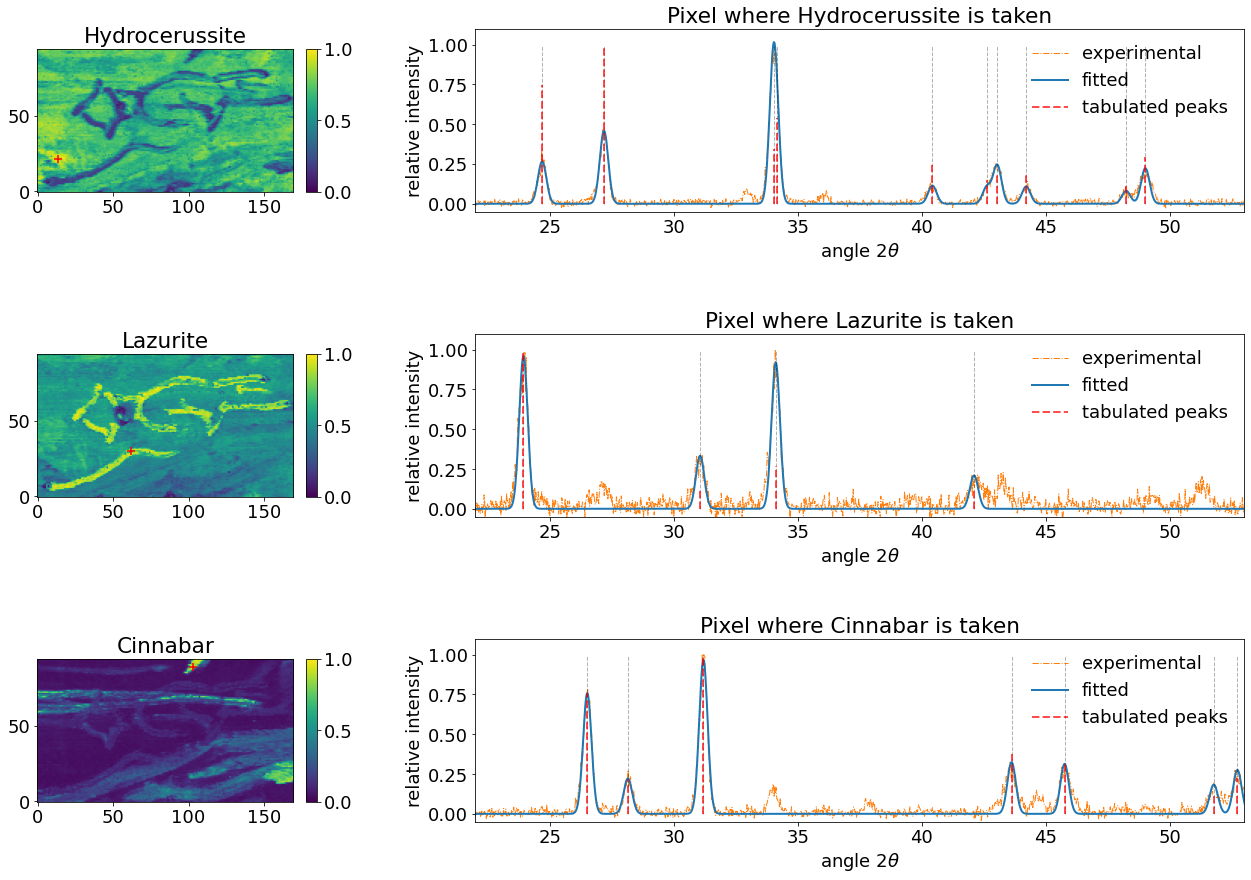

In [25]:
rcParams['font.size'] = 18
#matrix_to_show = overlap_area
matrix_to_show = criterion

fig, axs = subplots(len(gm.phases), 2, figsize = (18, 4*len(gm.phases)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 7)

for i, phase in enumerate(experimental_phases):

    if type(phase) == Phase:
        point = phase['point']
    else:
        point = phase[0]['point']
    x, y = gm.get_x_y(point)
    g = gm[point][i]

    if (len(experimental_phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_to_show[..., i], vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    #cbar.set_label('overlap')
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(phase.label)

    if (len(experimental_phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    #g.fit_cycle(gamma = True, steps = 128,a=True,s=True)
    print(g.label, (x, y), point, g.opt)
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    g.plot(c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Pixel where {phase.label} is taken')
    legend(frameon=False)

    spectrum_to_save = array((g.spectrum.counts, g.spectrum.intensity)).T
    savetxt(f'{path_results}Point ({x}, {y}) - selection for {phase.label} - raw counts and intensity.dat', spectrum_to_save, fmt = ['%d', '%.4f'])

savefig(f'{path_figures}pixel selection for each phase.png', bbox_inches = 'tight', dpi = 300)
show()

### Select the phase and correct the point where it is taken

In [29]:
def correct_point(experimental_phases, idx_phase, gm, x, y):
    gn = gm.get_pixel(x, y)[idx_phase]
    phase = gn.make_phase()
    phase.set_name('created_%d'%idx_phase)
    phase.set_point(gm.get_index(x, y))
    experimental_phases[idx_phase] = phase

In [30]:
idx_phase = 4
print(f'Selected {experimental_phases[idx_phase].label} among {len(experimental_phases)} phases.')

Selected Greenockite among 5 phases.


In [31]:
correct_point(experimental_phases, 4, gm, 145, 34)
#correct_point(experimental_phases, 5, gm, 145, 34)

### Save maps as PNG

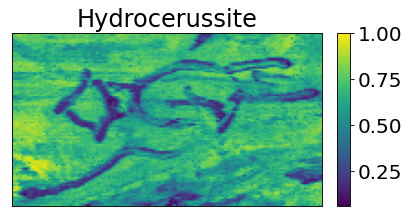

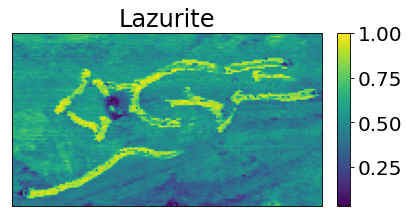

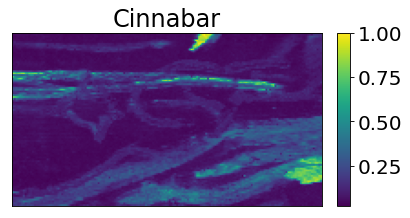

In [26]:
rcParams['font.size'] = 18

for idx_phase, phase in enumerate(gm.phases):
    fig, ax  = subplots(figsize=(5,3))
    fig.set_dpi(80)
    title(phase.label)
    im = imshow(criterion[..., idx_phase],
                #vmin = 0, vmax = 1,
                origin = 'lower', cmap = 'viridis')
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_yticks([])
    ax.set_xticks([])

    savefig(path_figures + phase.label + ' - criterion.png',
                bbox_inches = 'tight', dpi = 600)
show()

### Save TIF files

In [27]:
matrix_components_tiff = criterion
for p in range(criterion.shape[2]):
    matrix_components_tiff[..., p] = matrix_components_tiff[..., p] / matrix_components_tiff[..., p].max()
matrix_components_tiff = flip((matrix_components_tiff * 65535).astype('uint16'), axis = [0])

for idx_phase,phase in enumerate(gm.phases):
    img = Image.fromarray(matrix_components_tiff[..., idx_phase])
    img.save(path_results + phase.label + '.tiff')

# Save .cif files

In [28]:
for phase in experimental_phases:
    filename = path_database_exp + phase.label + '.cif'
    print(filename)
    phase.save_cif(filename)

databaseEXP/Munch/M491/ProfiloXRD/Hydrocerussite.cif
databaseEXP/Munch/M491/ProfiloXRD/Lazurite.cif
databaseEXP/Munch/M491/ProfiloXRD/Cinnabar.cif


# Explore one pixel with decomposition of experimental phases

In [29]:
x, y = 20, 40

cs = ChiSearch(experimental_phases, gm.get_pixel(x, y).spectrum, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
cs.fit_cycle(steps = 8, chi = True)
#cs.search()

In [30]:
rcParams['font.size'] = 18
#matrix_to_show = overlap_area
matrix_to_show = criterion

fig, axs = subplots(len(cs), 2, figsize = (18, 4*len(cs)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 7)

for i, g in enumerate(cs):
    if (len(cs) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_to_show[..., i], vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(g.label)

    if (len(cs) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    plot(cs[0].theta, cs.z_decomposed()[:, i], c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.annotate(f'chi: {cs.chi.squeeze()[i]:.3f}', xy = (0.05, 0.95),
        xycoords = 'axes fraction', horizontalalignment = 'left', verticalalignment = 'top')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(g.label)
    legend(frameon=False)

show()

In [31]:
rcParams['font.size'] = 18

fig, ax = subplots(figsize = (15, 3))
sca(ax)
cs[0].plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
plot(cs[0].theta, cs.z(), c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
ax.set_xlim(min_theta, max_theta)
ax.legend(loc = 'upper right')
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('rescaled intensity')
ax.set_title('Fit total')
fig.set_dpi(80)
show()

# Fit errrors

Plotting the histograms and maps of the error for each phase. 

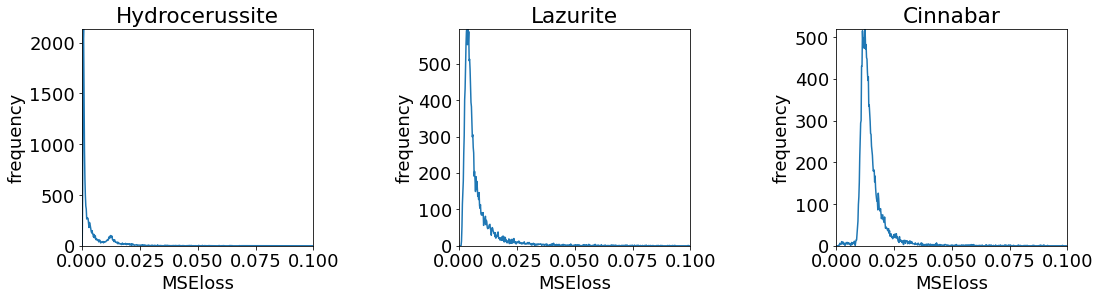

In [32]:
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (5 * n_of_columns, 4 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    h, b = histogram(MSEloss[:, :, i], bins = 512,range = (0, 0.1))
    ax.plot(b[:-1], h)
    ax.set_xlim(0, b.max())
    ax.set_ylim(0, h.max())
    ax.set_xlabel('MSEloss')
    ax.set_ylabel('frequency')
    ax.set_title(phase.label)
show()

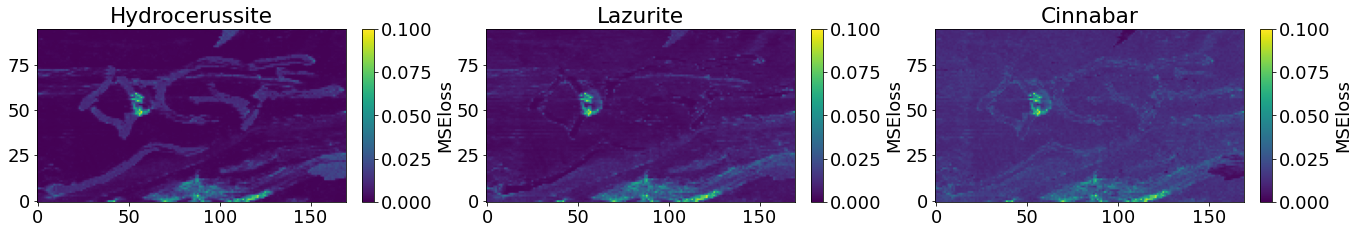

In [33]:
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (6 * n_of_columns, 5 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    h, b = histogram(MSEloss[:, :, i], bins = 512,range = (0, 0.1))
    ax.set_title(phase.label)
    im = ax.imshow(MSEloss[:, :, i], vmin = 0, vmax = 0.1)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    cbar.set_label('MSEloss')
show()

# Search for secondary phases

#### Smooth data

In [34]:
step = 3
method = 'mean'
#method = 'max'

data_smooth = data.generate_smooth(step, method)

Generating smooth data...
Removing background...
Done.
Done.


#### Refit primary phases on smoothed data

In [35]:
%%time
gm1 = GammaMap().from_data(data_smooth, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

gm1 = gm1.search()

overlap_area_1 = gm1.overlap_area()
criterion_1 = overlap_area_1 * data_smooth.rescaling**0.5

Using 8 CPUs
CPU times: user 11.7 s, sys: 1.73 s, total: 13.5 s
Wall time: 19.9 s


#### Fit secondary phases

In [36]:
%%time

phases_secondary = [barite, hematite, bone, spinel2]

gm2 = GammaMap_Secondary().from_data(gm1, data_smooth, phases_secondary, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)

gm2 = gm2.fit_cycle(steps = 6, gamma = True)

overlap_area_compare_2 = gm2.overlap_area_compare()
criterion_2 = overlap_area_compare_2 * data_smooth.rescaling**0.5

Using 8 CPUs
CPU times: user 23.9 s, sys: 3.3 s, total: 27.2 s
Wall time: 30.7 s


# Plots

### Primary phases

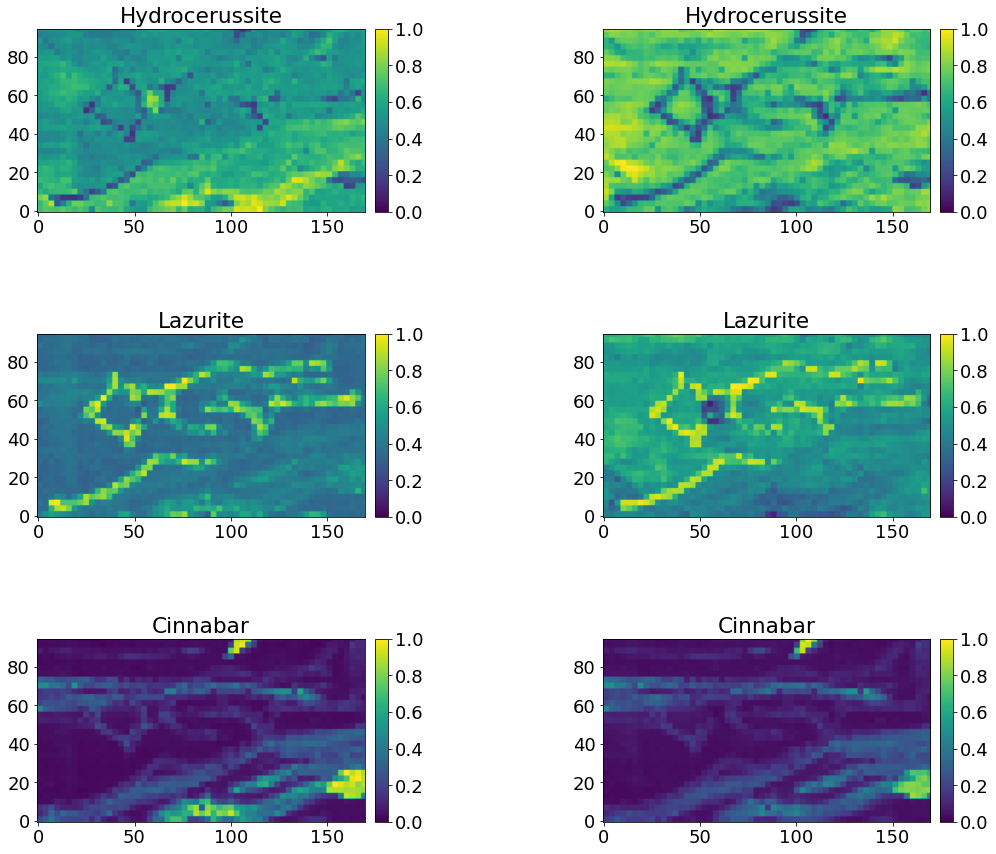

In [37]:
%matplotlib inline
rcParams['font.size'] = 18

fig, axs = subplots(len(gm1.phases), 2, figsize = (15, 4 * len(gm1.phases)))
fig.tight_layout(h_pad = 5, w_pad = 5)

for i, phase in enumerate(gm1.phases):
    ax = axs[i, 0]
    ax.set_title(phase.label)
    matrix_plot = overlap_area_1[..., i]
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

    ax = axs[i, 1]
    ax.set_title(phase.label)
    matrix_plot = criterion_1[..., i]
    matrix_plot /= matrix_plot.max()
    p = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

show()

### Secondary phases

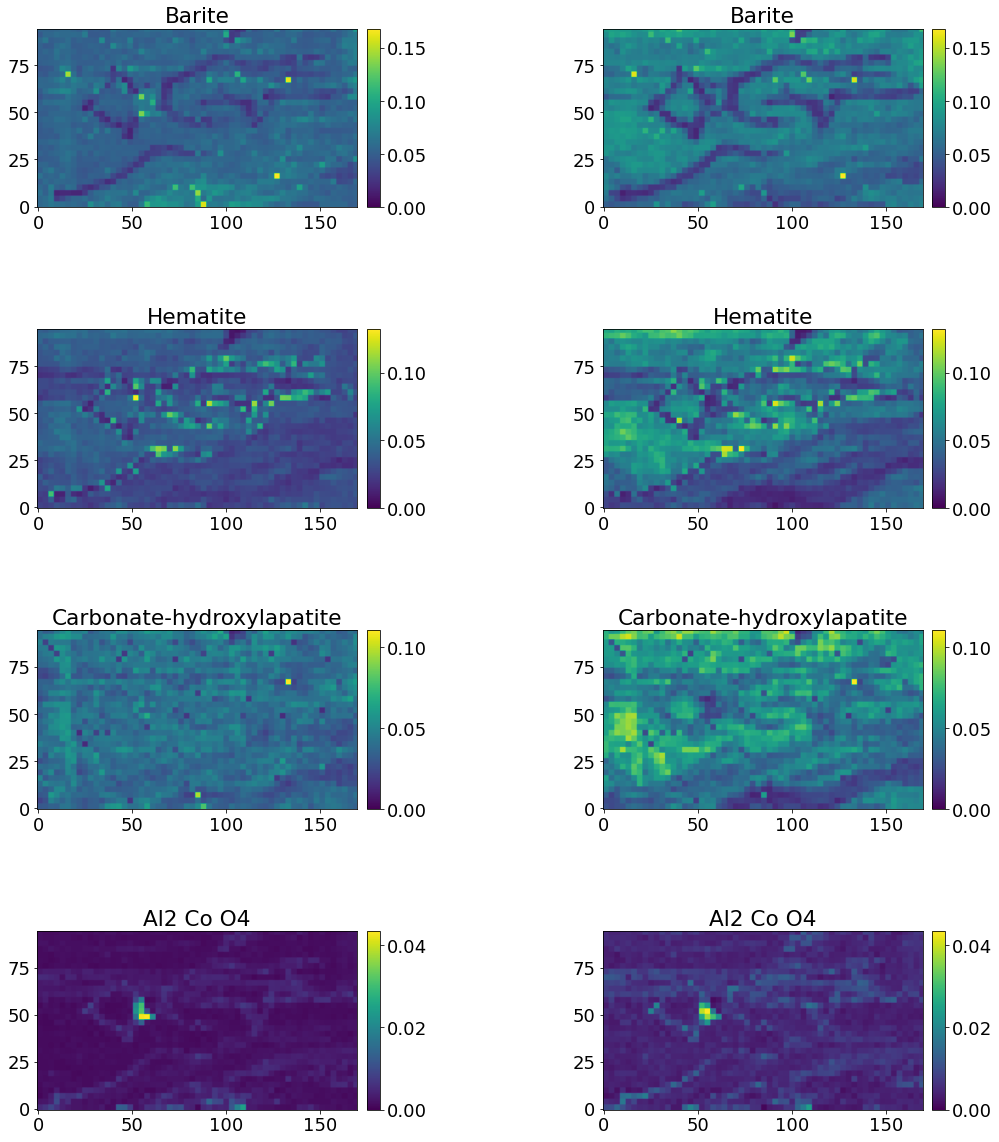

In [38]:
%matplotlib inline
rcParams['font.size'] = 18

fig, axs = subplots(len(gm2.phases), 2, figsize = (15, 4 * len(gm2.phases)))
fig.tight_layout(h_pad = 5, w_pad = 5)

for i, phase in enumerate(gm2.phases):
    ax = axs[i, 0]
    ax.set_title(phase.label)
    matrix_plot = overlap_area_compare_2[..., i]
    #matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

    ax = axs[i, 1]
    ax.set_title(phase.label)
    matrix_plot = criterion_2[..., i]
    #matrix_plot /= matrix_plot.max()
    p = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

show()

### Verify overlap in chosen pixel

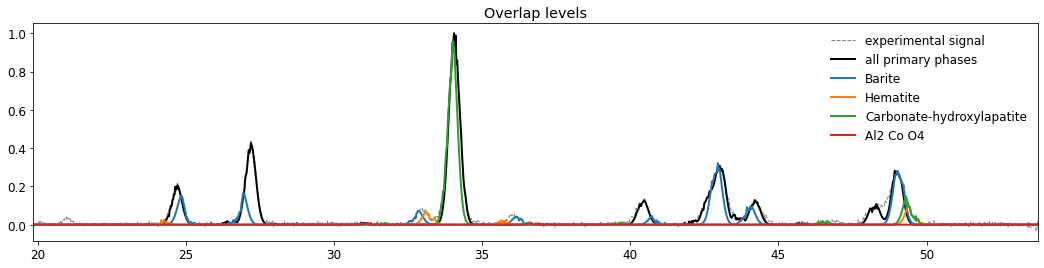

In [39]:
x, y = 10, 15
rcParams['font.size'] = 12

gs2 = gm2.get_pixel(x, y)

fig, ax = subplots(figsize = (18, 4))
theta = gs2.gammasearch_1[0].theta
ax.plot(theta, gs2.intensity, c = 'grey', ls = '--', lw = 1, label = 'experimental signal')
ax.plot(theta, gs2.gammasearch_1.overlap_total(), c = 'black', ls = '-', lw = 2, label = 'all primary phases')
for j in range(len(gs2)):
    ax.plot(theta, gs2.overlap()[j], ls = '-', lw = 2, label = gs2[j].phase.label)

legend(frameon = False)
ax.set_xlim(theta[0], theta[-1])
ax.set_title('Overlap levels')
show()